# HR Attrition Analysis

Data Sources: https://www.kaggle.com/datasets/anshika2301/hr-analytics-dataset

### 1. Data Preparation

In [660]:
import  pandas as pd
from    sklearn.ensemble import RandomForestClassifier
import  matplotlib.pyplot as plt
import seaborn as sns
# Removing Columns and Rows output truncation
pd.set_option('display.max_columns', None)

# load dataset
df = pd.read_csv("input/HR_Analytics.csv")

In [661]:
# get the basic info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmpID                     1480 non-null   object 
 1   Age                       1480 non-null   int64  
 2   AgeGroup                  1480 non-null   object 
 3   Attrition                 1480 non-null   object 
 4   BusinessTravel            1480 non-null   object 
 5   DailyRate                 1480 non-null   int64  
 6   Department                1480 non-null   object 
 7   DistanceFromHome          1480 non-null   int64  
 8   Education                 1480 non-null   int64  
 9   EducationField            1480 non-null   object 
 10  EmployeeCount             1480 non-null   int64  
 11  EmployeeNumber            1480 non-null   int64  
 12  EnvironmentSatisfaction   1480 non-null   int64  
 13  Gender                    1480 non-null   object 
 14  HourlyRa

#### 1.1 Identifying and removing single unique value

In [662]:
df.nunique()

EmpID                       1470
Age                           43
AgeGroup                       5
Attrition                      2
BusinessTravel                 4
DailyRate                    886
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EmployeeNumber              1470
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1349
SalarySlab                     4
MonthlyRate                 1427
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptio

In [663]:
print('Over18: ', df.Over18.unique())
print('EmployeeCount: ', df.EmployeeCount.unique())
print('StandardHours: ', df.StandardHours.unique())
print('EmployeeNumber: ', len(df.EmployeeNumber))

Over18:  ['Y']
EmployeeCount:  [1]
StandardHours:  [80]
EmployeeNumber:  1480


In [664]:
# Columns with no statistical impact on the dataset an be safely removed from the dataframe
df.drop(['EmployeeCount', 'EmployeeNumber','Over18', 'StandardHours'], axis=1, inplace = True)

#### 1.2 Removing Empty/Nan Values

In [665]:
# Counting NaN values in all columns
# [df[col].isna().any() for col in df.columns]
nan_count = df.isna().sum()
print(nan_count)

EmpID                        0
Age                          0
AgeGroup                     0
Attrition                    0
BusinessTravel               0
DailyRate                    0
Department                   0
DistanceFromHome             0
Education                    0
EducationField               0
EnvironmentSatisfaction      0
Gender                       0
HourlyRate                   0
JobInvolvement               0
JobLevel                     0
JobRole                      0
JobSatisfaction              0
MaritalStatus                0
MonthlyIncome                0
SalarySlab                   0
MonthlyRate                  0
NumCompaniesWorked           0
OverTime                     0
PercentSalaryHike            0
PerformanceRating            0
RelationshipSatisfaction     0
StockOptionLevel             0
TotalWorkingYears            0
TrainingTimesLastYear        0
WorkLifeBalance              0
YearsAtCompany               0
YearsInCurrentRole           0
YearsSin

In [666]:
# Removing Nan/empty values with KNN Imputation
from sklearn.impute import KNNImputer
# Create KNNImputer instance with 3 nearest neighbors
imputer = KNNImputer(n_neighbors=3)
# Specify the column to impute
column_to_impute = 'YearsWithCurrManager'
# Apply KNN imputation to the specified column
df[column_to_impute] = imputer.fit_transform(df[[column_to_impute]])

# Counting NaN values in the 'YearsWithCurrManager' column
nan_count = df.isna().sum()
print(nan_count)

EmpID                       0
Age                         0
AgeGroup                    0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
SalarySlab                  0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithC

#### 1.3 Reshaping the dataframe

In [667]:
# Reorder Columns by moving all categrical filds at the start.
numerics=['float64', 'int64']
cat_fields = df.select_dtypes(exclude=numerics)
non_cat_fields = df.select_dtypes(exclude='object')

cat_fields.describe().T

,count,unique,top,freq
EmpID,1480,1470,RM1467,2
AgeGroup,1480,5,26-35,611
Attrition,1480,2,No,1242
BusinessTravel,1480,4,Travel_Rarely,1042
Department,1480,3,Research & Development,967
EducationField,1480,6,Life Sciences,607
Gender,1480,2,Male,889
JobRole,1480,9,Sales Executive,329
MaritalStatus,1480,3,Married,679
SalarySlab,1480,4,Upto 5k,753


In [668]:
# print('BusinessTravel: ', df.BusinessTravel.unique())
# print('JobRole: ', df.JobRole.unique())
# print('Department: ', df.Department.unique())
# print('EducationField: ', df.EducationField.unique())

In [669]:
# Subtituting shorter values for Ordinal dataset --> Visualisation
BusinessTravel_abbreviations = {
    'Travel_Rarely': 'Travel-Rarely',
    'Travel_Frequently': 'Travel-Freq',
    'Non-Travel': 'Non-Travel',
    'TravelRarely': 'Travel-Rarely'
}
JobRole_abbreviations = {
    'Laboratory Technician': 'Lab-Tech',
    'Sales Representative': 'Sales-Rep',
    'Research Scientist': 'Res-Sci',
    'Human Resources': 'HR',
    'Manufacturing Director': 'Mfg-Dir',
    'Sales Executive': 'Sales-Exec',
    'Healthcare Representative': 'Healthcare-Rep',
    'Research Director': 'Res-Dir',
    'Manager': 'Mgr'
}
Department_abbreviations = {
    'Research & Development': 'R&D',
    'Sales': 'Sales',
    'Human Resources': 'HR'
}
EducationField_abbreviations = {
    'Life Sciences': 'Life-Sci',
    'Medical': 'Med',
    'Marketing': 'Mktg',
    'Technical Degree': 'Tech-Deg',
    'Other': 'Other',
    'Human Resources': 'HR'
}
df['BusinessTravel'] = df['BusinessTravel'].replace(BusinessTravel_abbreviations)
df['JobRole'] = df['JobRole'].replace(JobRole_abbreviations)
df['Department'] = df['Department'].replace(Department_abbreviations)
df['EducationField'] = df['EducationField'].replace(EducationField_abbreviations)

In [670]:
# Concatenate the numpy arrays to Reorder the dataset
columns_names_reorders = pd.concat([pd.Series(cat_fields.columns.values), pd.Series(non_cat_fields.columns.values)], ignore_index=True)
df = df[columns_names_reorders]
df.head()

,EmpID,AgeGroup,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,SalarySlab,OverTime,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,RM297,18-25,Yes,Travel-Rarely,R&D,Life-Sci,Male,Lab-Tech,Single,Upto 5k,No,18,230,3,3,3,54,3,1,3,1420,25233,1,13,3,3,0,0,2,3,0,0,0,0.0
1,RM302,18-25,No,Travel-Rarely,Sales,Med,Female,Sales-Rep,Single,Upto 5k,No,18,812,10,3,4,69,2,1,3,1200,9724,1,12,3,1,0,0,2,3,0,0,0,0.0
2,RM458,18-25,Yes,Travel-Freq,Sales,Mktg,Male,Sales-Rep,Single,Upto 5k,Yes,18,1306,5,3,2,69,3,1,2,1878,8059,1,14,3,4,0,0,3,3,0,0,0,0.0
3,RM728,18-25,No,Non-Travel,R&D,Life-Sci,Male,Res-Sci,Single,Upto 5k,No,18,287,5,2,2,73,3,1,4,1051,13493,1,15,3,4,0,0,2,3,0,0,0,0.0
4,RM829,18-25,Yes,Non-Travel,R&D,Med,Male,Lab-Tech,Single,Upto 5k,No,18,247,8,1,3,80,3,1,3,1904,13556,1,12,3,4,0,0,0,3,0,0,0,0.0


In [671]:
df.select_dtypes(exclude=numerics).describe().T

,count,unique,top,freq
EmpID,1480,1470,RM1467,2
AgeGroup,1480,5,26-35,611
Attrition,1480,2,No,1242
BusinessTravel,1480,3,Travel-Rarely,1050
Department,1480,3,R&D,967
EducationField,1480,6,Life-Sci,607
Gender,1480,2,Male,889
JobRole,1480,9,Sales-Exec,329
MaritalStatus,1480,3,Married,679
SalarySlab,1480,4,Upto 5k,753


#### 1.3 Removing Duplicate identified with EmpID(RM14767)

In [672]:
#Drop duplicate values from teh dataframe:
df.drop_duplicates(subset='EmpID', keep='first', inplace=True)
# Display the updated DataFrame
df.select_dtypes(exclude=numerics).describe().T

,count,unique,top,freq
EmpID,1470,1470,RM297,1
AgeGroup,1470,5,26-35,606
Attrition,1470,2,No,1233
BusinessTravel,1470,3,Travel-Rarely,1043
Department,1470,3,R&D,961
EducationField,1470,6,Life-Sci,606
Gender,1470,2,Male,882
JobRole,1470,9,Sales-Exec,326
MaritalStatus,1470,3,Married,673
SalarySlab,1470,4,Upto 5k,749


# 2. Exploratory Data Analysis (EDA)

In [673]:
eda = df.copy()
eda.drop(['EmpID'], axis = 1, inplace=True)
eda.groupby(["Attrition"]).size()

Attrition
No     1233
Yes     237
dtype: int64

<Axes: ylabel='count'>

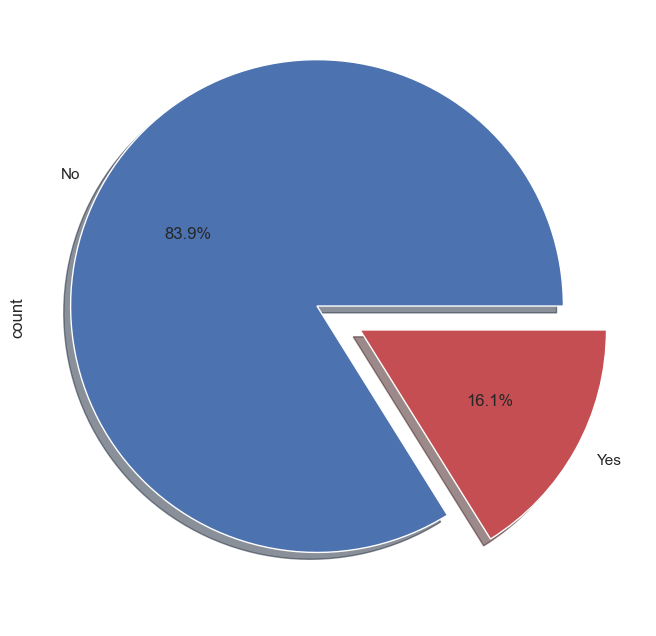

In [674]:
plt.figure(figsize=(8,8))
sns.set(style='whitegrid')
eda['Attrition'].value_counts().plot(kind='pie',explode=[0.1,0.1],autopct='%1.1f%%',shadow=True,colors=['b','r'])

In [675]:
# Changing binary representation of our target variable to 1 & 0
eda['Attrition'] = eda['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

In [676]:
eda.describe().T

,count,mean,std,min,25%,50%,75%,max
Attrition,1470.0,0.161224,0.367863,0.0,0.0,0.0,0.00,1.0
Age,1470.0,36.923810,9.135373,18.0,30.0,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.0,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.0,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.0,3.0,4.00,5.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.0,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.0,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.0,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.0,2.0,3.00,5.0
JobSatisfaction,1470.0,2.728571,1.102846,1.0,2.0,3.0,4.00,4.0


In [677]:
hr_data_num  = eda.select_dtypes(exclude='object')

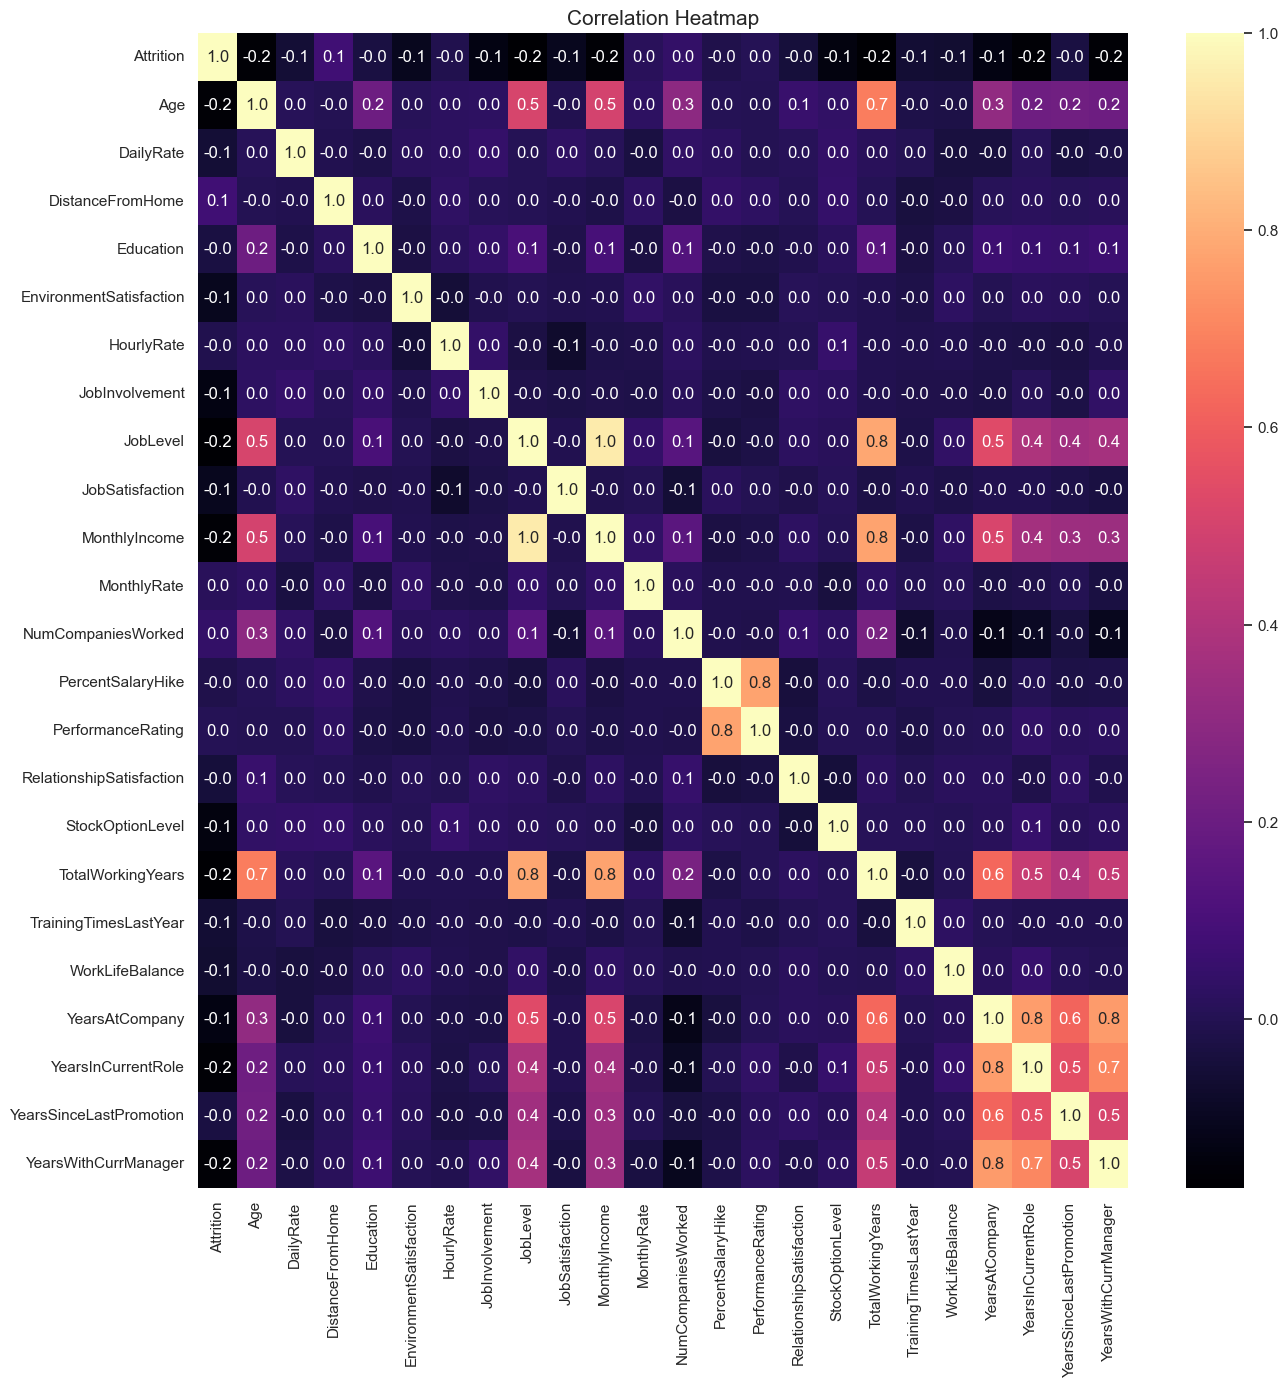

In [678]:
# Use Pearson correlation to find pairwise correlation of all variables
plt.figure(figsize=(15,15))
sns.heatmap(hr_data_num.corr(method='pearson'), annot=True, fmt='.1f', cmap='magma')
plt.title('Correlation Heatmap', fontsize=15)
plt.show()

In [679]:
# Categorical Exploration
# print(plt.style.available)
plt.style.use('seaborn-v0_8-pastel')
plt.figure(figsize=(8,6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

#### Education Analysis

EducationField
HR          0.259259
Life-Sci    0.146865
Med         0.135776
Mktg        0.220126
Other       0.134146
Tech-Deg    0.242424
dtype: float64

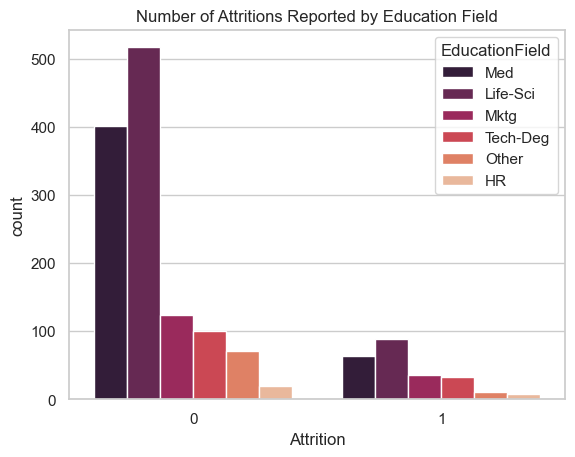

In [680]:
sns.countplot(x=eda['Attrition'],hue='EducationField',data=eda, palette = 'rocket').set_title("Number of Attritions Reported by Education Field")
# Percentage Table
eda[(eda["Attrition"] == 1)].groupby(["EducationField"]).size() / eda.groupby(["EducationField"]).size()

This chart illustrates the number of attritions reported by education field. While the technical degree, marketing, and human resources fields represent a small portion of the dataset, the attrition rates in these fields are notably higher. Examine the percentage of employees who have left, broken down by education field in table above.

This shows that HR, Technical Degree, and Marketing fields have the highest attrition percentages.

#### OverTime Analysis

OverTime
No     0.104364
Yes    0.305288
dtype: float64

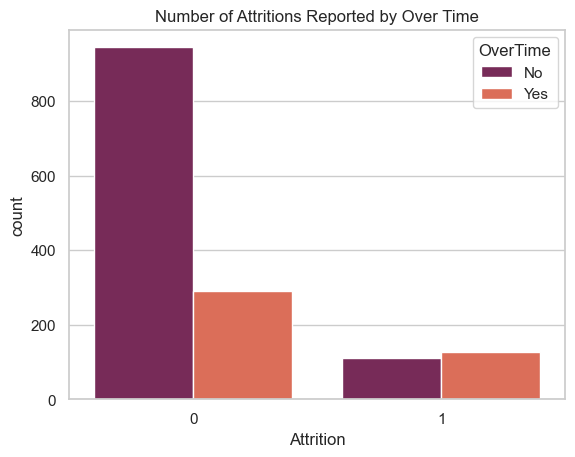

In [681]:
sns.countplot(x=eda['Attrition'],hue='OverTime',data=eda, palette = 'rocket').set_title("Number of Attritions Reported by Over Time")
# Percentage Table
eda[(eda["Attrition"] == 1)].groupby(["OverTime"]).size() / eda.groupby(["OverTime"]).size()

About 30.5% of overtime employees have attrited, meaning that it is a factor that needs to be accounted for employee attrition.

#### Travel Analysis

BusinessTravel
Non-Travel       0.080000
Travel-Freq      0.249097
Travel-Rarely    0.149569
dtype: float64

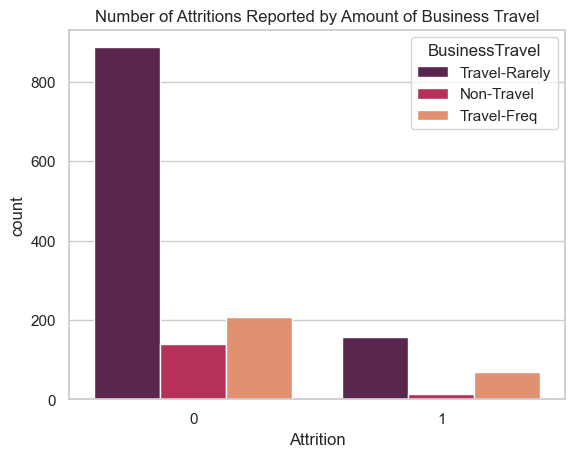

In [682]:
sns.countplot(x=eda['Attrition'],hue='BusinessTravel',data=eda, palette = 'rocket').set_title("Number of Attritions Reported by Amount of Business Travel")
# Percentage Table
eda[(eda["Attrition"] == 1)].groupby(["BusinessTravel"]).size() / eda.groupby(["BusinessTravel"]).size()

The attrition rate for the Travel-Frequently group is significantly higher compared to the other two groups.

#### Gender Analysis

Gender
Female    0.147959
Male      0.170068
dtype: float64

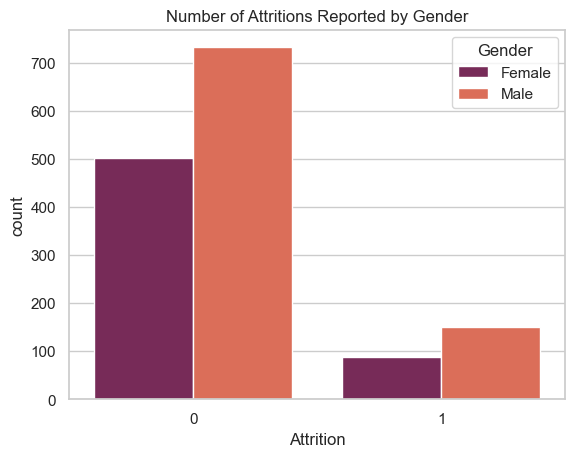

In [683]:
sns.countplot(x=eda['Attrition'],hue='Gender',data=eda, palette = 'rocket').set_title("Number of Attritions Reported by Gender")
# Percentage Table
eda[(eda["Attrition"] == 1)].groupby(["Gender"]).size() / eda.groupby(["Gender"]).size()

This graph reveals that approximately 237 employees left the company, while around 1230 employees remained. The dataset also has a higher proportion of male employees. The statistics indicate that 15% of female employees and 17% of male employees attrited. However, since male employees make up a larger portion of the sample, this difference is unlikely to be statistically significant.

#### Marital  Analysis

MaritalStatus
Divorced    0.100917
Married     0.124814
Single      0.255319
dtype: float64

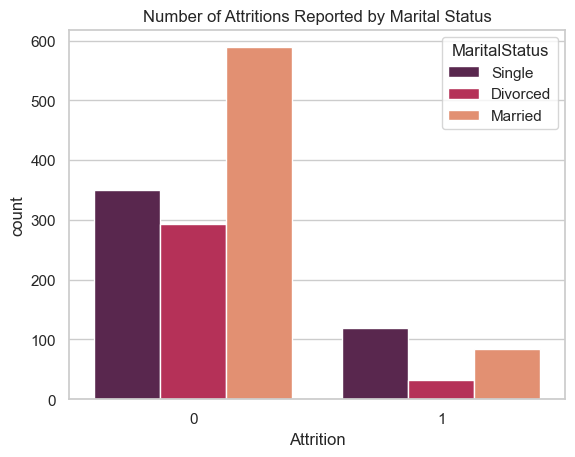

In [684]:
sns.countplot(x=eda['Attrition'],hue='MaritalStatus',data=eda, palette = 'rocket').set_title("Number of Attritions Reported by Marital Status")
# Percentage Table
eda[(eda["Attrition"] == 1)].groupby(["MaritalStatus"]).size() / eda.groupby(["MaritalStatus"]).size()

The graph reveles that employees with single status is more likely to leave whereas the majority of the employee are married and only a small percentage of them chooses to leave the company.

#### Jobs Analysis

JobRole
HR                0.230769
Healthcare-Rep    0.068702
Lab-Tech          0.239382
Mfg-Dir           0.068966
Mgr               0.049020
Res-Dir           0.025000
Res-Sci           0.160959
Sales-Exec        0.174847
Sales-Rep         0.397590
dtype: float64

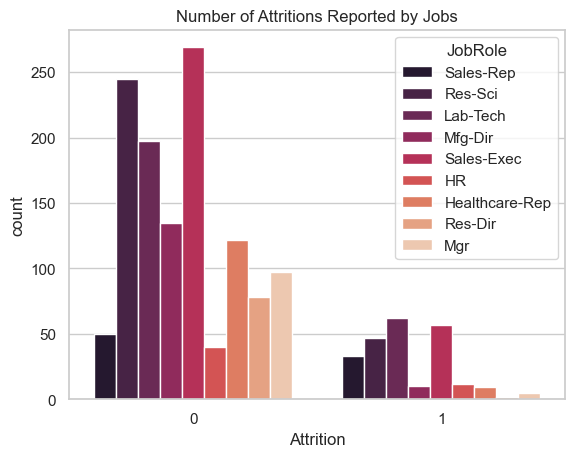

In [685]:
sns.countplot(x=eda['Attrition'],hue='JobRole',data=eda, palette = 'rocket').set_title("Number of Attritions Reported by Jobs")
# Percentage Table
eda[(eda["Attrition"] == 1)].groupby(["JobRole"]).size() / eda.groupby(["JobRole"]).size()

These statistics display the attrition percentages by job role, with sales representatives making up almost 40% of the employees who left, followed by laboratory technicians and human resources roles.

#### Stock Option Analysis

StockOptionLevel
0    0.244057
1    0.093960
2    0.075949
3    0.176471
dtype: float64

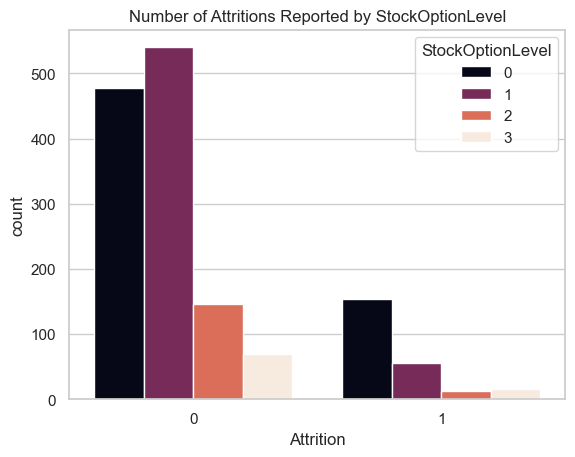

In [686]:
sns.countplot(x=eda['Attrition'],hue='StockOptionLevel',data=eda, palette = 'rocket').set_title("Number of Attritions Reported by StockOptionLevel")
# Percentage Table
eda[(eda["Attrition"] == 1)].groupby(["StockOptionLevel"]).size() / eda.groupby(["StockOptionLevel"]).size()

# 3. Modeling (ML)

1. Data Preparation

In [687]:
#Binary features -- Gender, OverTime to 0 & 1
ml = eda.copy()
ml['Gender'] = ml['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
ml['OverTime'] = ml['OverTime'].apply(lambda x: 1 if x == 'Yes' else 0)

In [688]:
def target_encode(df, target_column):
    # Iterate over each column in the DataFrame
    for column in df.select_dtypes(include=['object', 'category']).columns:
        # Calculate the mean of the target for each category in the current column
        mean_values = df.groupby(column)[target_column].mean()
        
        # Replace the original categories with the corresponding mean values
        df[column] = df[column].map(mean_values)
    
    return df

In [689]:
ml = target_encode(ml, 'Attrition')
ml.head(5)

,AgeGroup,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,SalarySlab,OverTime,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.357724,1,0.149569,0.138398,0.146865,1,0.239382,0.255319,0.217623,0,18,230,3,3,3,54,3,1,3,1420,25233,1,13,3,3,0,0,2,3,0,0,0,0.0
1,0.357724,0,0.149569,0.206278,0.135776,0,0.397590,0.255319,0.217623,0,18,812,10,3,4,69,2,1,3,1200,9724,1,12,3,1,0,0,2,3,0,0,0,0.0
2,0.357724,1,0.249097,0.206278,0.220126,1,0.397590,0.255319,0.217623,1,18,1306,5,3,2,69,3,1,2,1878,8059,1,14,3,4,0,0,3,3,0,0,0,0.0
3,0.357724,0,0.080000,0.138398,0.146865,1,0.160959,0.255319,0.217623,0,18,287,5,2,2,73,3,1,4,1051,13493,1,15,3,4,0,0,2,3,0,0,0,0.0
4,0.357724,1,0.080000,0.138398,0.135776,1,0.239382,0.255319,0.217623,0,18,247,8,1,3,80,3,1,3,1904,13556,1,12,3,4,0,0,0,3,0,0,0,0.0


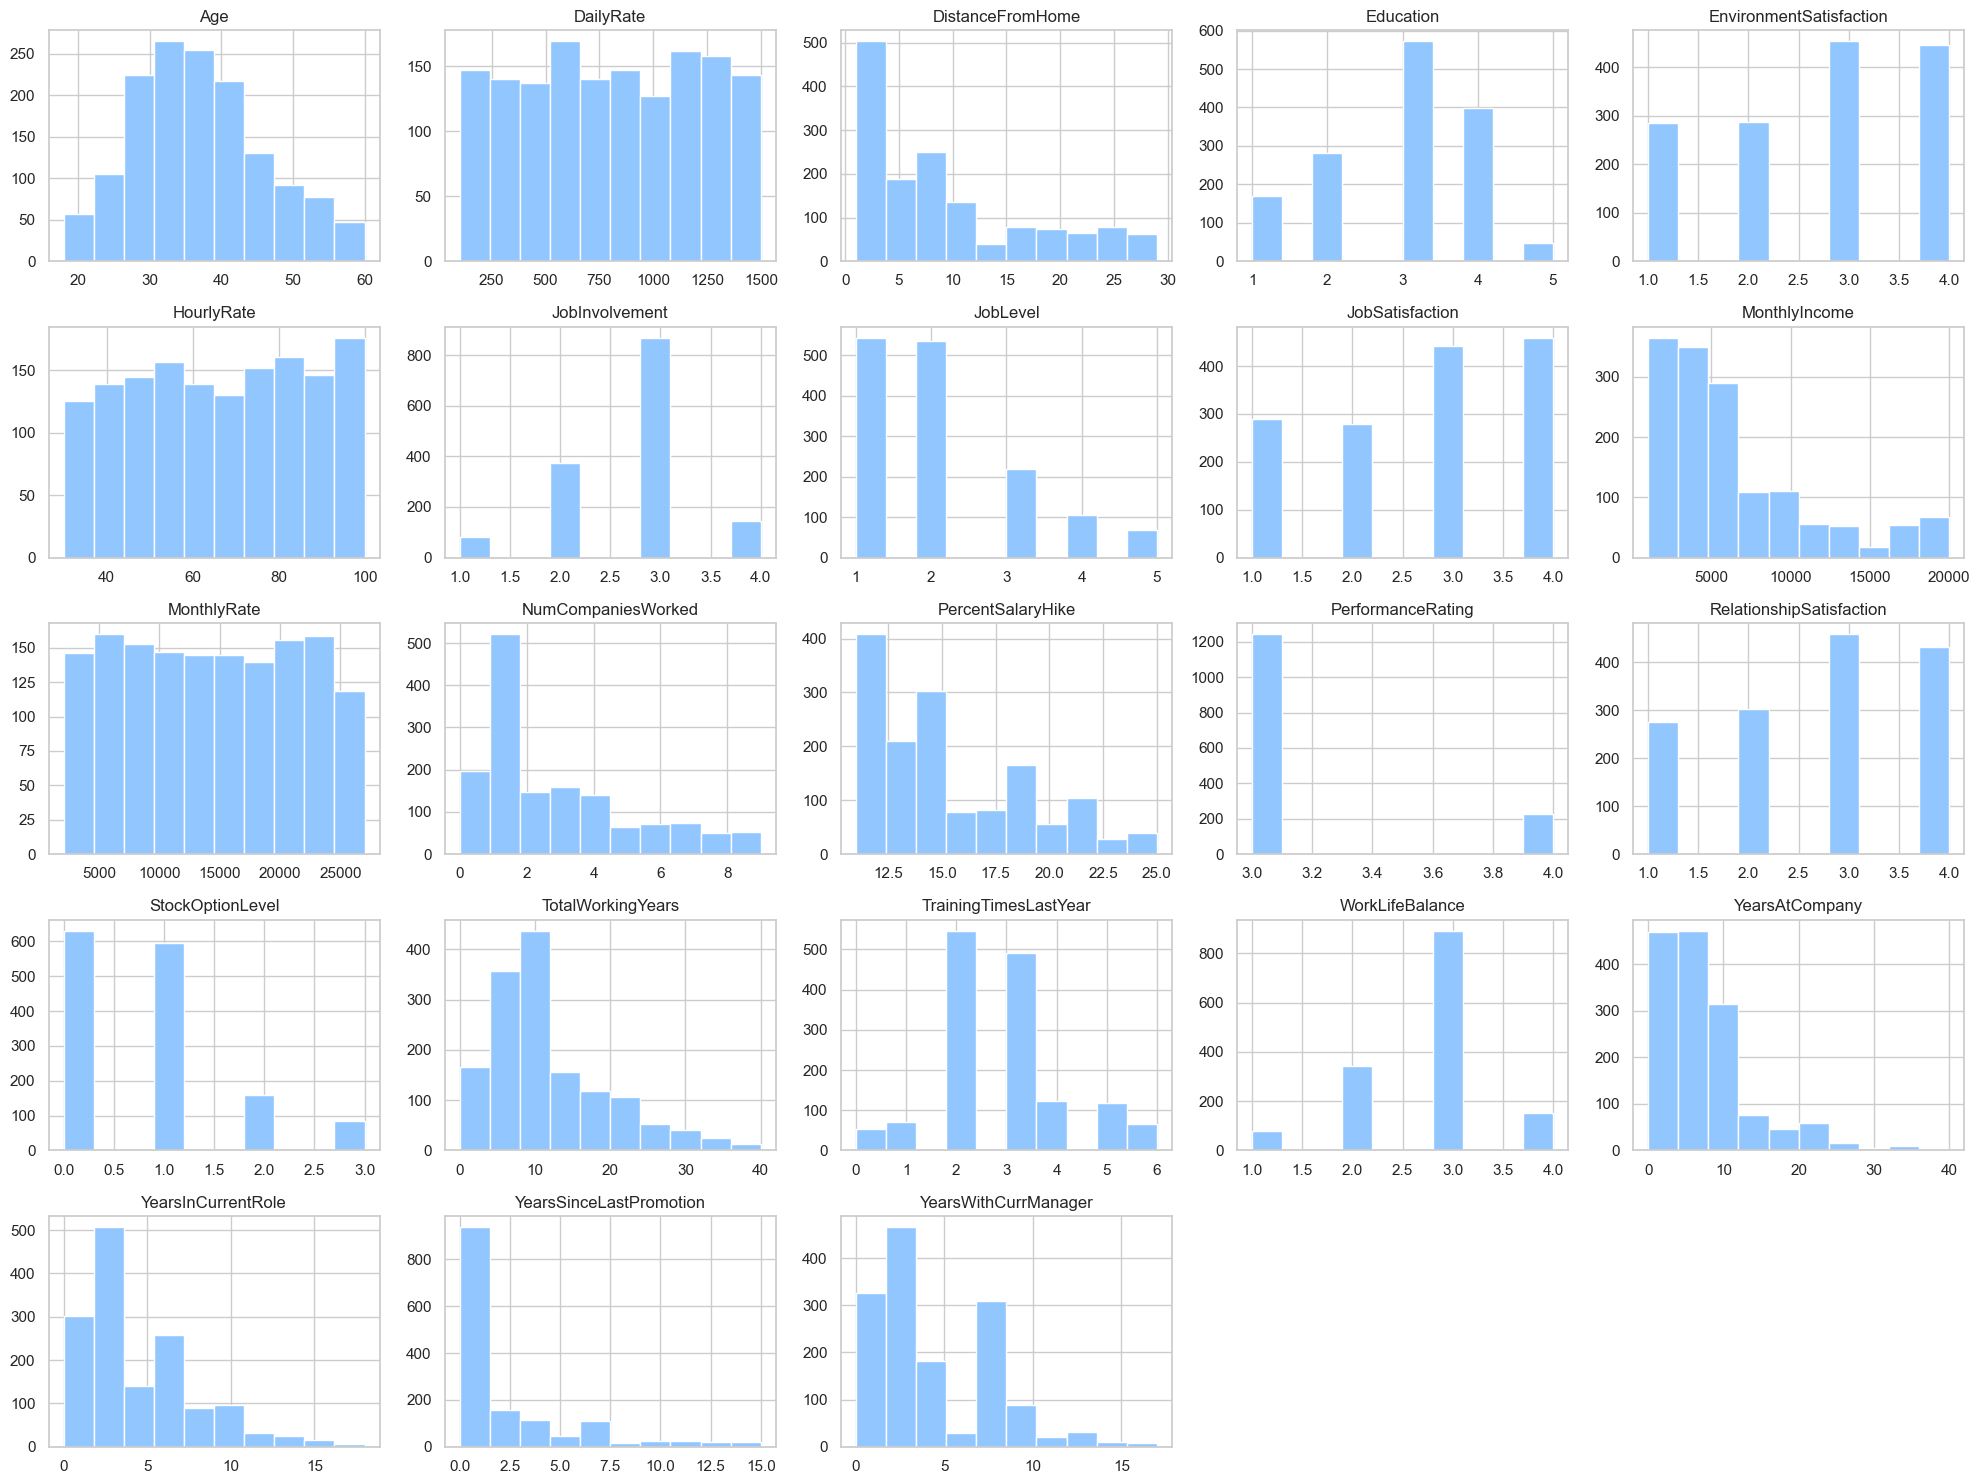

In [690]:
import matplotlib.pylab as plt
df.hist(figsize=(20,15))
plt.tight_layout()
plt.show()

2. Modeling

In [691]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

x, y= ml.drop(['Attrition'], axis = 1), ml['Attrition']

SMOTE - Resampling

In [692]:
from imblearn.over_sampling import SMOTE,SVMSMOTE
from collections import Counter
print('Orignal: ',Counter(y))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20)
smote=SVMSMOTE(sampling_strategy='minority',random_state=3)
x_train_sm,y_train_sm=smote.fit_resample(x_train,y_train)
print('SMOTE: ',Counter(y_train_sm)) 

Orignal:  Counter({0: 1233, 1: 237})
SMOTE:  Counter({1: 981, 0: 981})


In [693]:
model = RandomForestClassifier(n_jobs = -1)
model.fit(x_train_sm, y_train_sm)
model.score(x_test, y_test) # Accuracy

0.8843537414965986

In [694]:
# create the classifier with n_estimators = 100
model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs = -1)

# fit the model to the training set
model.fit(x_train, y_train)

# view the feature scores
feature_scores = pd.Series(model.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_scores

MonthlyIncome               0.067848
Age                         0.058708
DailyRate                   0.058021
OverTime                    0.050642
HourlyRate                  0.049170
MonthlyRate                 0.049162
DistanceFromHome            0.046831
TotalWorkingYears           0.045612
JobRole                     0.041041
YearsAtCompany              0.039904
YearsWithCurrManager        0.034732
NumCompaniesWorked          0.034072
JobSatisfaction             0.030574
PercentSalaryHike           0.030399
EnvironmentSatisfaction     0.028706
StockOptionLevel            0.028091
JobInvolvement              0.027446
YearsInCurrentRole          0.026314
TrainingTimesLastYear       0.026137
YearsSinceLastPromotion     0.025285
EducationField              0.025024
WorkLifeBalance             0.023761
RelationshipSatisfaction    0.021934
JobLevel                    0.020322
MaritalStatus               0.020135
AgeGroup                    0.019284
Education                   0.018459
B

In [695]:
Y_Pred = model.predict(x_test)

# Feature Importances
sorted_imp = dict(sorted(zip(model.feature_names_in_,model.feature_importances_), key=lambda x: x[1],reverse=True))
predictor_scores = pd.DataFrame.from_dict(sorted_imp, orient="index")
predictor_scores.to_csv("Output/predictor_scores.csv")

In [696]:
#Export the result as Processed data ready for visualisations.
Prediction = model.predict(x)
df['Prediction'] = Prediction
df.to_csv('Output/processed.csv')

**1. Observations**  
From the data analysis conducted on Notebook as well as Tablue dashboard, we identified several numerical variables correlated with attrition, including MonthlyIncome, OverTime, TotalWorkingYears, Age, DistanceFromHome, JobRole ,YearsAtCompany, DailyRate, HourlyRate, MonthlyRate.

In addition to these numerical variables, certain categorical variables also play a significant role. Specifically:

- Employees with backgrounds in technical degrees, human resources, and marketing fields exhibit higher attrition rates compared to those in medical, life sciences, and other fields.
- 30% of employees working overtime have left the company, compared to those who do not work overtime. Frequent business travel also correlates with higher attrition rates.
- Regarding job roles, nearly 40% of the attrited employees were sales representatives, followed by laboratory technicians and human resources positions.

**2. Insights and Recommendations**  
Based on these findings, we can derive the following recommendations for companies:

- Employees with backgrounds in technical degrees, human resources, and marketing should be closely monitored, particularly regarding their job roles.
- Companies should work to minimize overtime to boost job satisfaction.
- More incentives, such as reduced work hours and increased flexibility, should be offered to sales representatives, laboratory technicians, and human resources staff to reduce attrition.
- Companies should consider providing additional stock options to employees as a retention strategy.
- Across all roles, enhancing job involvement can help employees feel more connected to the company, reducing the likelihood of attrition.

**Conclusion**  
Through exploratory data analysis, we visualized correlations and demographic insights, identifying key variables that influence employee attrition. Using Random forest, we built a model with an accuracy around 86%, demonstrating that factors such as education, job roles, MonthlyIncome, and OverTime are significant drivers of attrition. Based on these insights, we proposed actionable recommendations for companies to prevent talent loss.